In [23]:
!pip install neurolib

In [25]:
!pip install mne

  Using cached pooch-1.8.1-py3-none-any.whl.metadata (9.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 8.0 MB/s eta 0:00:0000:0100:01
Using cached pooch-1.8.1-py3-none-any.whl (62 kB)
  Attempting uninstall: lazy-loader
    Found existing installation: lazy_loader 0.2
    Uninstalling lazy_loader-0.2:
      Successfully uninstalled lazy_loader-0.2


In [27]:
import numpy as np
import mne
from neurolib.models.model import Model

class EEGModel(Model):
    def __init__(self, params, leadfield_matrix, stimulus):
        # Define the state variable names
        self.state_vars = ["eeg_signal"]
        # Define the default output variable
        self.default_output = "eeg_signal"
        # Store the leadfield matrix
        self.leadfield_matrix = leadfield_matrix
        # Store the stimulus signal
        self.stimulus = stimulus
        # Initialize the base Model class
        super().__init__(self.integration, params)

    def integration(self, params):
        # Define the time vector
        t = np.linspace(0, params["duration"], int(params["duration"] / params["dt"]) + 1)
        # Initialize the EEG signal array
        eeg_signal = np.zeros((self.leadfield_matrix.shape[0], len(t)))

        # Simulate the EEG response to the stimulus using the leadfield matrix
        for i in range(1, len(t)):
            # Generate source activity based on the stimulus
            source_activity = np.zeros(self.leadfield_matrix.shape[1])
            if self.stimulus[i] == 1:  # Target stimulus
                source_activity[params["target_region"]] = np.sin(2 * np.pi * params["target_freq"] * t[i])
            elif self.stimulus[i] == -1:  # Non-target stimulus
                source_activity[params["non_target_region"]] = np.sin(2 * np.pi * params["non_target_freq"] * t[i])
            
            # Project the source activity to the sensor space using the leadfield matrix
            eeg_signal[:, i] = np.dot(self.leadfield_matrix, source_activity)

        return t, eeg_signal

# Example usage
params = {
    "dt": 0.01,
    "duration": 10.0,
    "target_freq": 10.0,  # Frequency of the EEG response to the target stimulus
    "non_target_freq": 5.0,  # Frequency of the EEG response to the non-target stimulus
    "target_region": 0,  # Index of the target region in the source space
    "non_target_region": 1,  # Index of the non-target region in the source space
}
leadfield_matrix = np.load('leadfield_matrix.npy')  # Load the leadfield matrix
stimulus = np.zeros(1001)  # Define your stimulus array here (e.g., square signal)

model = EEGModel(params, leadfield_matrix, stimulus)
model.run()
eeg_signal = model.output



FileNotFoundError: [Errno 2] No such file or directory: 'leadfield_matrix.npy'

In [35]:
import numba
import numpy as np
from numpy.random import random as rand
from neurolib.models.model import Model
from neurolib.optimize.evolution import Evolution

class EEGModel(Model):
    state_vars = ["eeg_signal"]
    default_output = "eeg_signal"
    init_vars = ["eeg_init"]
    params = dict(tau=10, K=1e-2, dt=1e-1, duration=100, stimulus_amplitude=1.0)
    
    def __init__(self, Cmat=np.zeros((1,1)), stimulus=np.zeros(1000)):
        self.params['Cmat'] = Cmat
        self.params['stimulus'] = stimulus
        super().__init__(self.timeIntegration, self.params)
        
    def timeIntegration(self, p):
        p['N'] = p['Cmat'].shape[0]  # number of nodes
        t = np.arange(1, p['duration'] / p['dt'] + 1)  # holds time steps
        eeg_signal = np.ndarray((p['N'], len(t) + 1))  # holds variable eeg_signal
        # either use predefined initial conditions or random ones
        eeg_signal[:, :1] = p['eeg_init'] if 'eeg_init' in p else rand((p['N'], 1))
        return njit_integrate(eeg_signal, t, p['tau'], p['K'], p['N'], p['Cmat'], p['dt'], p['stimulus'], p['stimulus_amplitude'])

    @numba.njit
    def njit_integrate(eeg_signal, t, tau, K, N, Cmat, dt, stimulus, stimulus_amplitude):
        for i in range(1, 1 + len(t)):  # loop over time
            inp = Cmat.dot(eeg_signal[:, i-1]) + stimulus_amplitude * stimulus[i-1]  # input vector with stimulus
            for n in range(N):  # loop over nodes
                eeg_signal[n, i] = eeg_signal[n, i-1] + (- eeg_signal[n, i-1] / tau + K * inp[n]) * dt  # model equations
        return t, eeg_signal

    def evalFunction(individual):
        # Convert the individual to a connectivity matrix
        Cmat = np.array(individual).reshape((n_nodes, n_nodes))
        
        # Create an instance of the EEGModel with the current Cmat
        model = EEGModel(Cmat=Cmat, stimulus=square_signal)
        
        # Run the model simulation
        model.run()
        
        # Access the generated EEG signal
        simulated_eeg_signal = model.output
        
        # Calculate the fitness based on the difference between the simulated and real EEG signals
        fitness = -np.mean((simulated_eeg_signal - real_eeg_signal) ** 2)
        
        return fitness,

# Define the parameter space for the connectivity matrix
n_nodes = 10  # Number of nodes in the network
parameterSpace = ParameterSpace(['Cmat'], [[0, 1]] * (n_nodes ** 2))

# Define other parameters for the evolutionary algorithm
weightList = [-1.0]  # Minimize the fitness
POP_SIZE = 20
NGEN = 10

# Create an instance of the Evolution class
evolution = Evolution(
    evalFunction=evalFunction,
    parameterSpace=parameterSpace,
    weightList=weightList,
    POP_SIZE=POP_SIZE,
    NGEN=NGEN
)



ImportError: dlopen(/Users/aliag/.pyenv/versions/3.9.2/lib/python3.9/site-packages/tables/utilsextension.cpython-39-darwin.so, 0x0002): symbol not found in flat namespace '_H5Lget_info'

/var/folders/by/2njwfm9x7sbdz_xdq73474s00000gn/T/ipykernel_47559/184100909.py:28: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  inp = Cmat.dot(eeg_signal[:, i-1]) + stimulus_amplitude * stimulus[i-1]  # input vector with stimulus


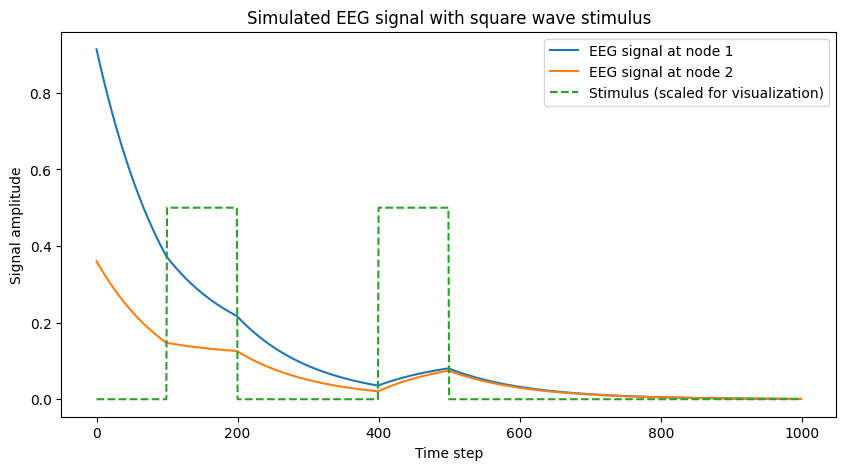

In [29]:
import matplotlib.pyplot as plt

# Define the connectivity matrix (for simplicity, we'll use a 2x2 identity matrix)
Cmat = np.eye(2)

# Define the square wave stimulus
duration = 1000  # duration in time steps
stimulus = np.zeros(duration)
stimulus[100:200] = 1  # a square pulse between timesteps 100 and 200
stimulus[400:500] = 1  # another square pulse between timesteps 400 and 500

# Create an instance of the EEGModel
model = EEGModel(Cmat=Cmat, stimulus=stimulus)

# Run the model simulation
model.run()

# Access the generated EEG signal
eeg_signal = model.output

# Plot the EEG signal
plt.figure(figsize=(10, 5))
plt.plot(eeg_signal[0], label='EEG signal at node 1')
plt.plot(eeg_signal[1], label='EEG signal at node 2')
plt.plot(stimulus * 0.5, label='Stimulus (scaled for visualization)', linestyle='--')
plt.xlabel('Time step')
plt.ylabel('Signal amplitude')
plt.legend()
plt.title('Simulated EEG signal with square wave stimulus')
plt.show()
